In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
import os
import json
import urllib2
import pylab as pl
%pylab inline

from __future__ import print_function
__author__='djc'

url = urllib2.urlopen("https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/fbb_matplotlibrc.json")
s = json.load(url)
pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


/Users/Daynan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print (nrg.columns)

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [3]:
##get PLUTO data

bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print (bsize.columns)

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d672310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12e4baa90>]], dtype=object)

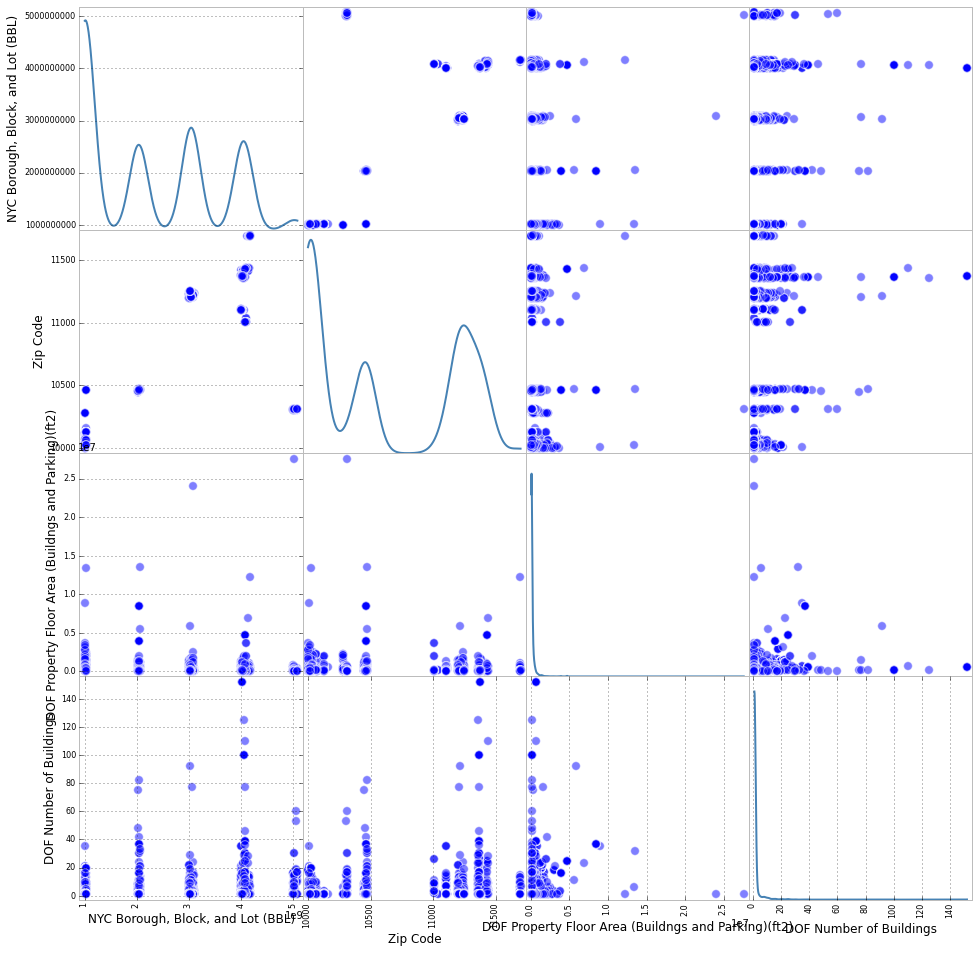

In [4]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


In [5]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

vfloat = np.vectorize(canconvert)

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [6]:
#create the indeces array here
indx_energy = vfloat(nrg['Site EUI(kBtu/ft2)'])
indx_area = vfloat(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

In [7]:
nrg['Site EUI(kBtu/ft2)'][~indx_energy]=float('NaN')
nrg['Site EUI(kBtu/ft2)'][indx_energy]= nrg['Site EUI(kBtu/ft2)'].astype(float)
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx_area]=float('NaN')
nrg['Reported Property Floor Area (Building(s)) (ft²)'][indx_area]=nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instanc

In [8]:
# checking conversions
#print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#print (nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float))
#print (bsize.BBL.astype(float))
#print (bsize.UnitsTotal.astype(float))

#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [9]:
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)']
bblnrgbsize = pd.merge(nrg, bsize, on='BBL')
print (bblnrgbsize.columns[0:50])

/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)
/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1049: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


Index([                              u'NYC Borough, Block, and Lot (BBL)',
                                                u'Co-reported BBL Status',
                                                      u'BBLs Co-reported',
                   u'Reported NYC Building Identificaiton Numbers (BINs)',
                                                         u'Street Number',
                                                           u'Street Name',
                                                             u'Borough_x',
                                                              u'Zip Code',
                                    u'DOF Benchmarking Submission Status',
                                                    u'Site EUI(kBtu/ft2)',
                                 u'Weather Normalized Site EUI(kBtu/ft2)',
                                                  u'Source EUI(kBtu/ft2)',
                               u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supp

once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1572: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(_values_from_object(key))
/Users/Daynan/anaconda/lib/python2.7/site-packages/pandas/core/index.py:743: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


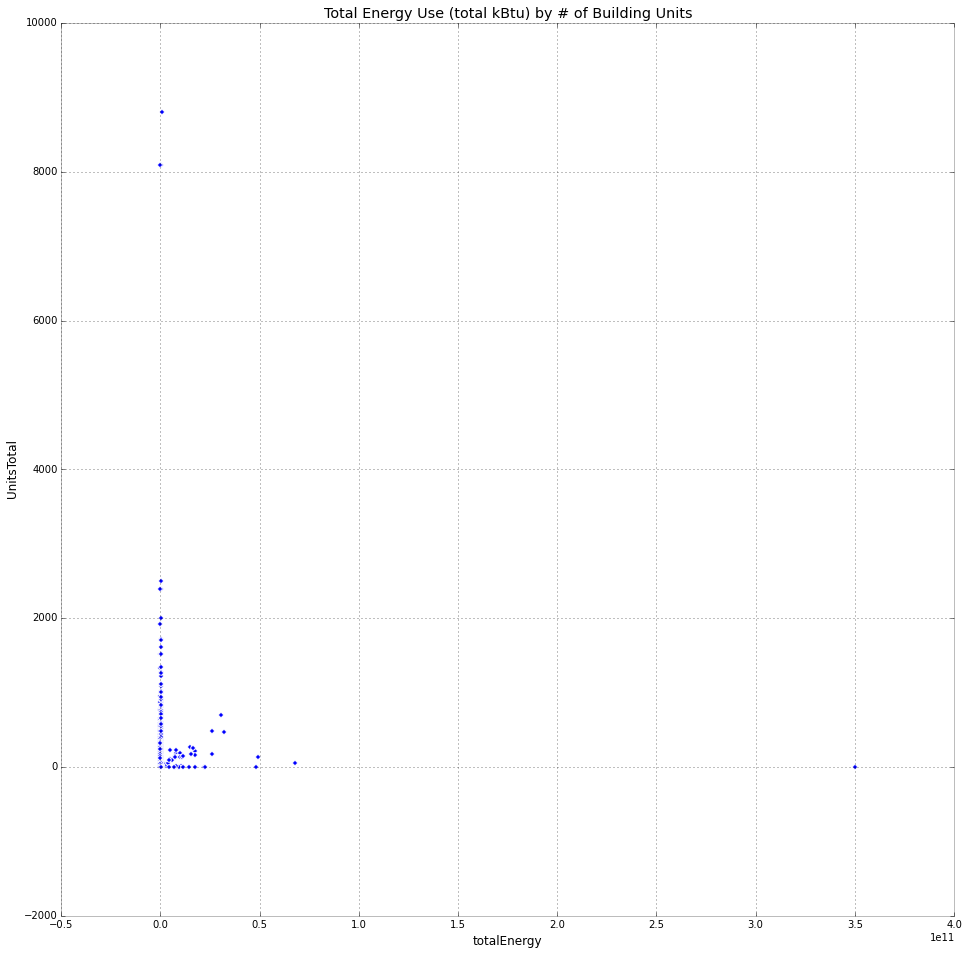

In [10]:
# Drop all NaN's
bblnrgbsize_cut = bblnrgbsize.dropna(subset=['Site EUI(kBtu/ft2)','UnitsTotal','BBL','Reported Property Floor Area (Building(s)) (ft²)']).copy()

# total energy
bblnrgbsize_cut['totalEnergy'] = bblnrgbsize_cut['Site EUI(kBtu/ft2)']*bblnrgbsize_cut['Reported Property Floor Area (Building(s)) (ft²)']

# slice only columns needed for plotting
bblnrgbsize_cut = bblnrgbsize_cut[['Site EUI(kBtu/ft2)','UnitsTotal','Reported Property Floor Area (Building(s)) (ft²)','totalEnergy', 'BBL']].copy()
bblnrgbsize_cut.plot(kind='scatter', x="totalEnergy", y="UnitsTotal", figsize=(16,16), title='Total Energy Use (total kBtu) by # of Building Units')

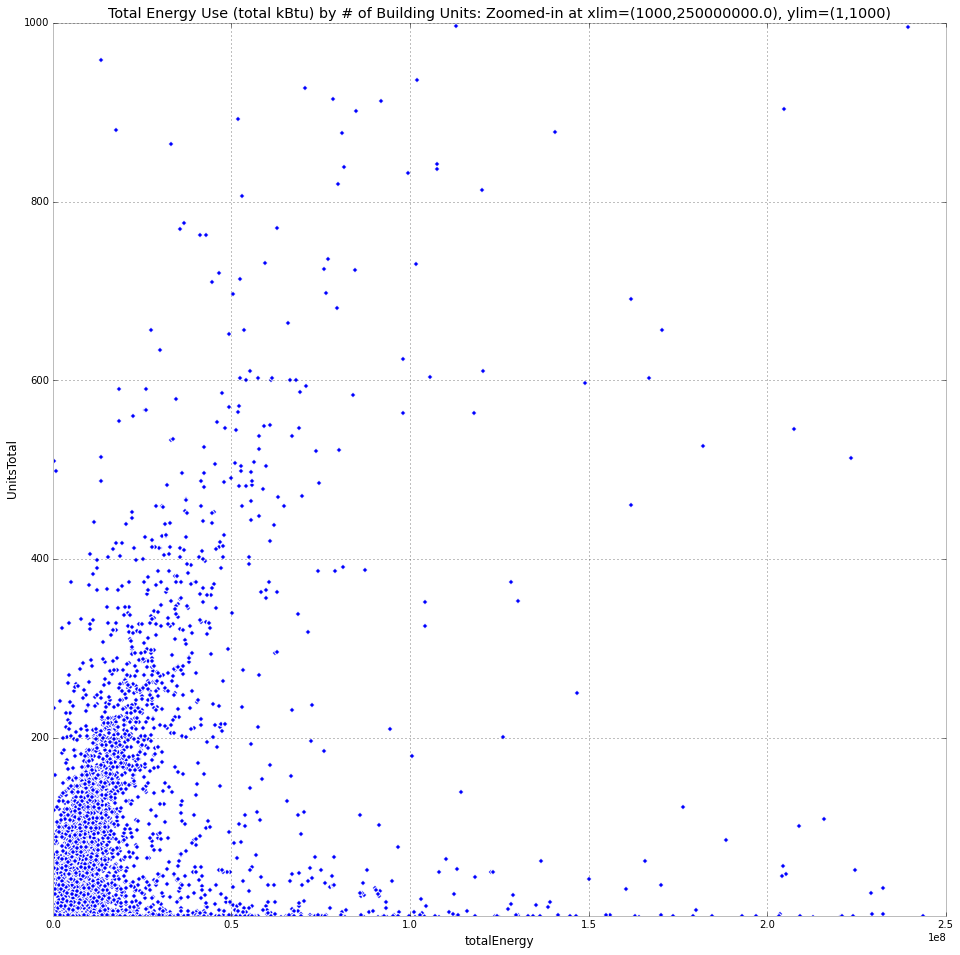

In [11]:
# zoom in a bit
x_in,x_out = 1000,2.5e8
y_in,y_out = 1,1000

bblnrgbsize_cut.plot(kind='scatter', x="totalEnergy", y="UnitsTotal", figsize=(16,16), xlim=(x_in,x_out), ylim=(y_in,y_out), title='Total Energy Use (total kBtu) by # of Building Units: Zoomed-in at xlim=({},{}), ylim=({},{})'.format(x_in,x_out,y_in,y_out))

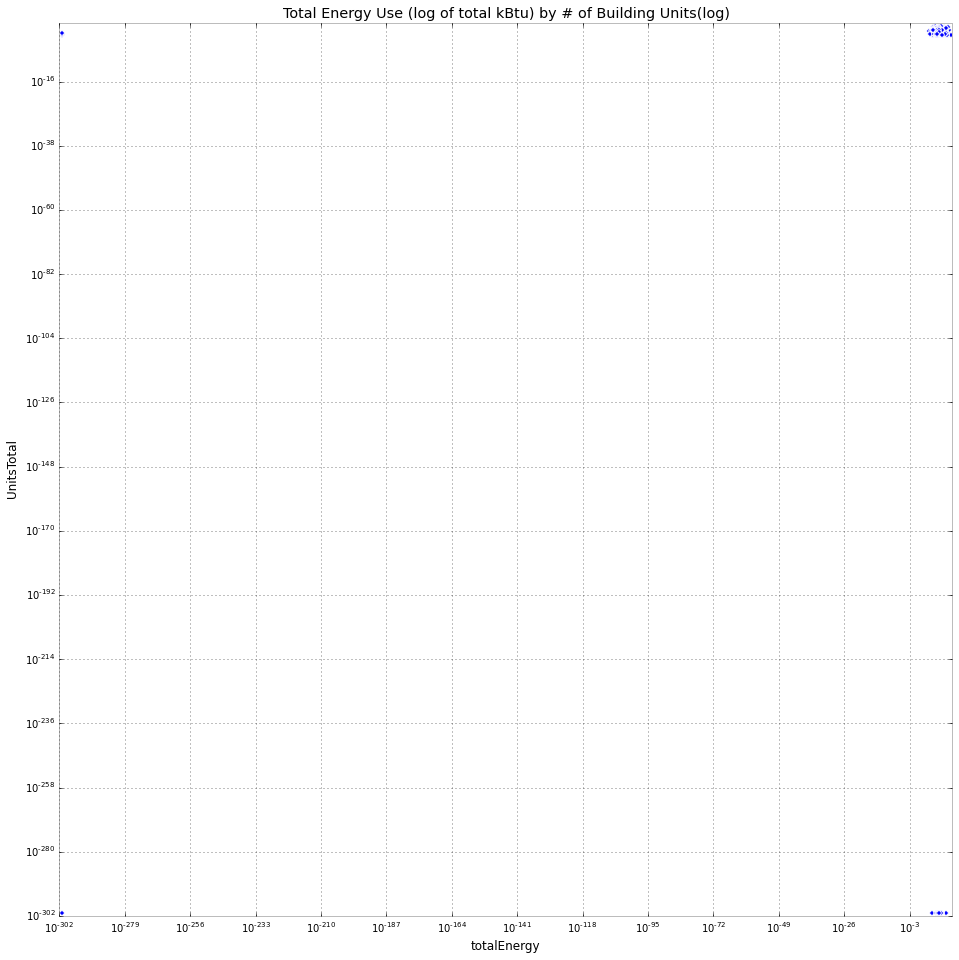

In [12]:
# log of x,y
bblnrgbsize_cut.plot(kind='scatter', x="totalEnergy", y="UnitsTotal", figsize=(16,16), loglog=True, title='Total Energy Use (log of total kBtu) by # of Building Units(log)')

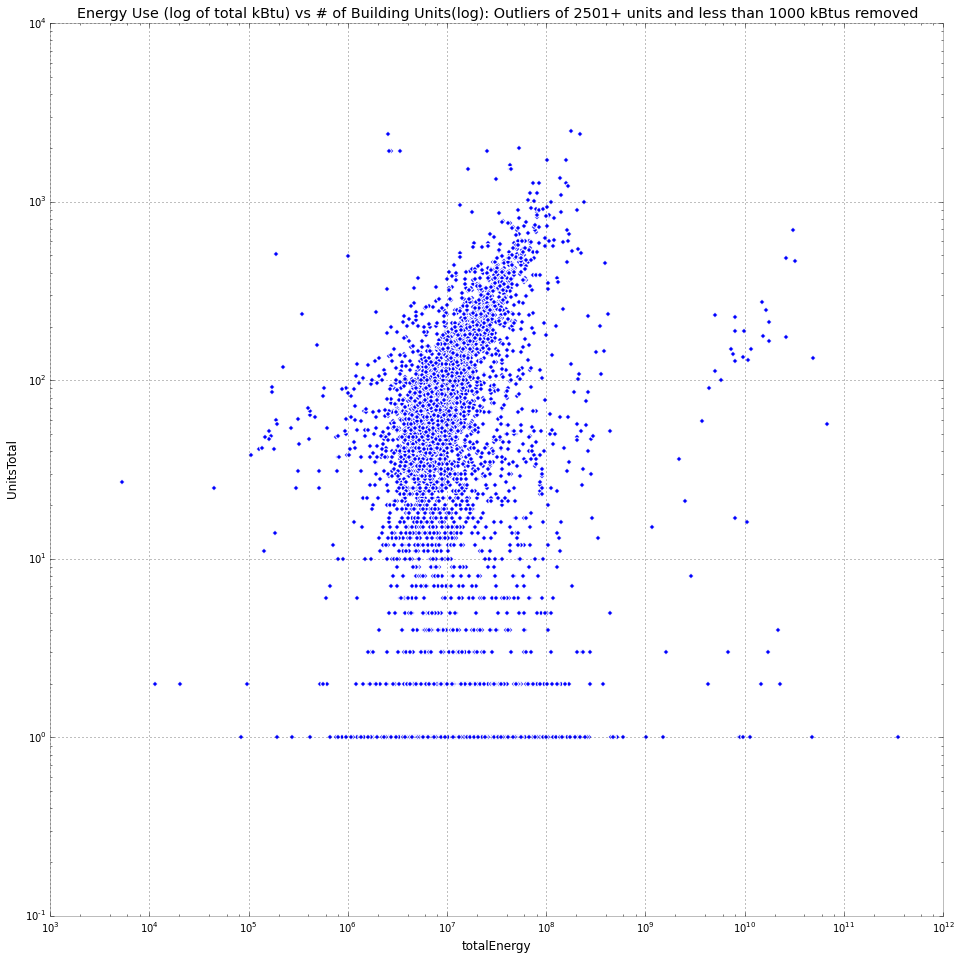

In [13]:
# Cut outliers: 
# while some "properties" may include multiple bldgs,
# let's set remove records above a reasonable # of units/property or those with 0 units
bld_lim = 2501
cut2 = bblnrgbsize_cut[(bblnrgbsize_cut.UnitsTotal<bld_lim) & (bblnrgbsize_cut.UnitsTotal >0)]

# let's also remove anything below a low kBtu as misreported
e_lim = 1000
cut3 = cut2[cut2.totalEnergy>e_lim]

# plot
cut3.plot(kind='scatter', x="totalEnergy", y="UnitsTotal", figsize=(16,16), loglog=True, title='Energy Use (log of total kBtu) vs # of Building Units(log): Outliers of {}+ units and less than {} kBtus removed'.format(bld_lim,e_lim))

linear regression slope                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.913e+04
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        01:49:49   Log-Likelihood:                -5235.2
No. Observations:                5003   AIC:                         1.047e+04
Df Residuals:                    5002   BIC:                         1.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2350      0

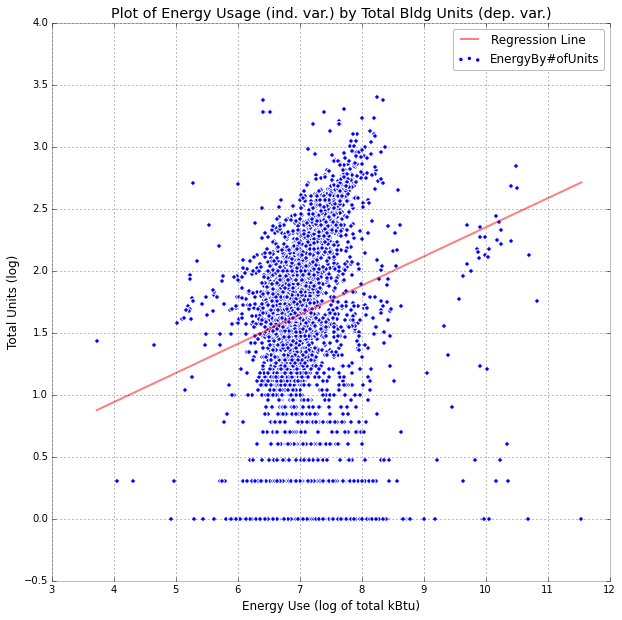

In [33]:
import statsmodels.api as sm

# regression function
def logreg(x, y): 
    model = sm.OLS(np.log10(y), np.log10(x), missing='drop')
    
    myfit = model.fit()
    print ("linear regression slope {}".format(myfit.summary()))
    return myfit

# define x or ind. variable
list_x = list(cut3.totalEnergy)

# y or dependent variable
list_y = list(cut3.UnitsTotal)

# plot
myregress = logreg(list_x,list_y)
regline = np.linspace(min(np.log10(list_x)),max(np.log10(list_x)),100)

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Plot of Energy Usage (ind. var.) by Total Bldg Units (dep. var.)')
ax.scatter(np.log10(list_x), np.log10(list_y), label = "EnergyBy#ofUnits")
ax.plot(regline, myregress.predict(regline), 'r', alpha=0.5, label='Regression Line')

ax.set_xlabel('Energy Use (log of total kBtu)')
ax.set_ylabel('Total Units (log)')
ax.legend()

linear regression slope                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.913e+04
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        01:51:53   Log-Likelihood:                -12084.
No. Observations:                5003   AIC:                         2.417e+04
Df Residuals:                    5002   BIC:                         2.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             3.6316      0

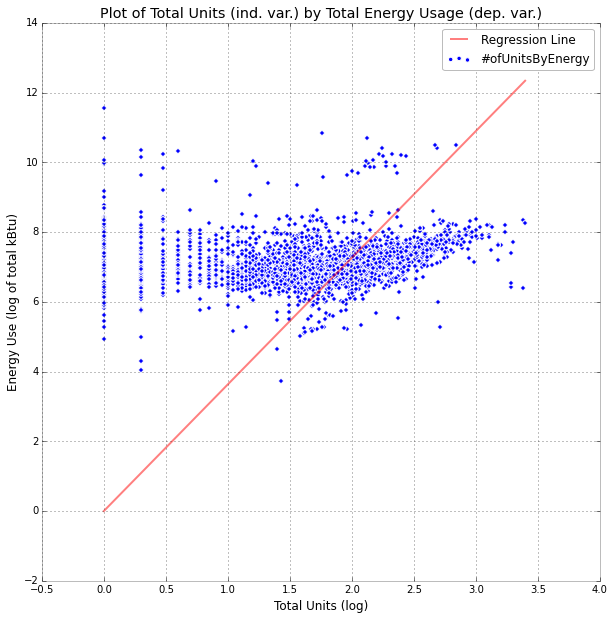

In [35]:
# flip ind and dep variable

# define x or ind. variable
list_x2 = list(cut3.UnitsTotal)

# y or dependent variable
list_y2 = list(cut3.totalEnergy)

# plot
myregress2 = logreg(list_x2,list_y2)
regline2 = np.linspace(min(np.log10(list_x2)),max(np.log10(list_x2)),100)

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Plot of Total Units (ind. var.) by Total Energy Usage (dep. var.)')
ax.scatter(np.log10(list_x2), np.log10(list_y2), label = "#ofUnitsByEnergy")
ax.plot(regline2, myregress2.predict(regline2), 'r', alpha=0.5, label='Regression Line')

ax.set_xlabel('Total Units (log)')
ax.set_ylabel('Energy Use (log of total kBtu)')
ax.legend()

###Try making a fit for energy vs units AND a fit for units vs energy. tell me which is better.


###look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??¶


####The energy as ind. variable by building units as dep. variable seems to be a better fit than the other way around, based on the smaller absolute value of the log-likelihood (|5235| for former, |12084| for the latter).

####However, the log-likelihood score is very high for both comparisons, so a likelihood ratio test is not recommended.

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

linear regression slope                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                 2.913e+04
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        02:24:05   Log-Likelihood:                -5235.2
No. Observations:                5003   AIC:                         1.047e+04
Df Residuals:                    5002   BIC:                         1.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2350      0

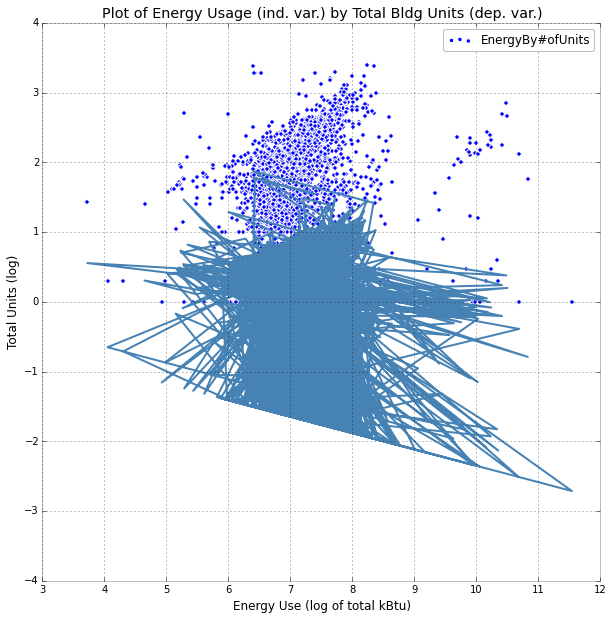

In [42]:
# polyfit regression function
polyreg = np.polyfit(np.log10(list_x),np.log10(list_y),2)

# plot
myregress = logreg(list_x,list_y)
#regline = np.linspace(min(np.log10(list_x)),max(np.log10(list_x)),100)

fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('Plot of Energy Usage (ind. var.) by Total Bldg Units (dep. var.)')
ax.scatter(np.log10(list_x), np.log10(list_y), label = "EnergyBy#ofUnits")
ax.plot(np.log10(list_x), np.log10(list_y)-myregress.predict(np.log10(list_x)))

ax.set_xlabel('Energy Use (log of total kBtu)')
ax.set_ylabel('Total Units (log)')
ax.legend()

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [ ]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)